# **DLIP Tutorial - PyTorch**
# CIFAR-10 Classification using PyTorch - Part 1
Y.-K. Kim
(updated 2024. 5. 9) 

===================

The purpose of this tutorial is to learn how to build a simple CNN model for classification of CIFAR-10

You must do: **Tutorial_PyTorch_MNIST_MLP_2024**  before this tutorial

* Part 1:  Create LeNet5 CNN model and Train with opendataset (CIFAR10)
* Part 2:  Test with loading trained model(LeNet-5)
* Part 3:  Create and Train a CNN model(VGG-16) with opendataset

## For CoLab Usage:

1. Download this notebook
2. Then, open in Colab

# Setup Pytorch and Numpy and Device


In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Select GPU or CPU for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'Device name: {torch.cuda.get_device_name(0)}') 

Using cuda device
Device name: NVIDIA GeForce RTX 4080 Laptop GPU


# Prepare Datasets: Input and Output


1. Loading OpenDataset (CIFAR-10) from Pytorch data
* ``Dataset``:  stores the samples and their corresponding labels
* ``DataLoader`` wraps an iterable around the ``Dataset``.


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Load CIFAR-10
https://www.cs.toronto.edu/~kriz/cifar.html

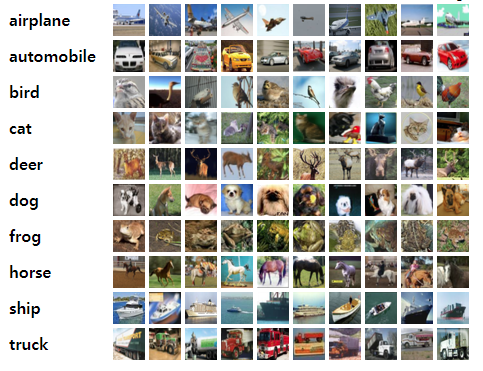

In [3]:
# Download Dataset from TorchVision MNIST
# Once, downloaded locally, it does not download again.
#
# NOTE: LeNet uses 1x32x32 input.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])

# Download train data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,   #converts 0~255 value to 0~1 value.
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

print(f"train dataset length = {len(training_data)}")
print(f"test  dataset length = {len(test_data)}")

100.0%


train dataset length = 50000
test  dataset length = 10000


2. Use  ``DataLoader`` to  make dataset iterable.
* supports automatic batching, sampling, shuffling and multiprocess data loading. 



In [4]:
# Create data loaders.
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32]) torch.int64
Shape of y: torch.Size([64]) torch.int64


3. Plot some training data


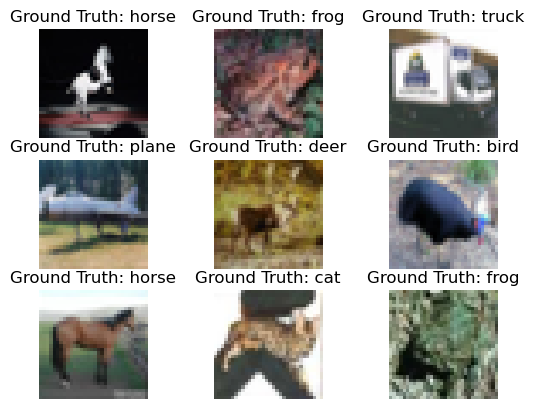

In [5]:
# Visualize some Datasets
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.imshow(np.transpose((images[index] * 0.5 + 0.5).numpy(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)

# Define model

create a class that inherits from nn.Module


* Define the layers of the network in  __init__ function
* Specify Forward network in the **forward function.**


![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)
>>> LeNet-5 Architecture. Credit: [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz)

**The following part is heavily inspired by** https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb


#### Architecture
* **\[C1] Conv:** Input (32x32x1) to Output (28x28x6) by 5x5 filters, `relu`
* **\[S2] Pooling** : Input (28x28x6) to Output (14x14x6), `maxPooling 2x2`
* **\[C3] Conv:** Input (14x14x6) to Output (10x10x16) by 5x5 filters, `relu`
* **\[S4] Pooling** : Input (10x10x16) to Output (5x5x16), `maxPooling 2x2`
* **Flatten** : Input (5x5x16) to Output 1D 1x (5 \* 5 \* 16)
* **\[F5] FC** : Input (1x5 \* 5 \* 16) to Output (1x120) , `relu`
* **\[F6] FC** : Input (1x120) to Output (1x84) , `relu`
* **\[OUTPUT]** : Input (1x84) to Output (1x10)


In [6]:
# Model Architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        # Feature Extraction 
        self.conv_layers = nn.Sequential(            
            # C1
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            # S2
            nn.MaxPool2d(2, 2),
            # C3
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            # S4
            nn.MaxPool2d(2, 2)
        )
        
        self.flatten = nn.Flatten()
        
        # Classifier
        self.fc_layers = nn.Sequential(
            # F5
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            # F6
            nn.Linear(120, 84),
            nn.ReLU(),
            # OUTPUT
            nn.Linear(84, 10)
        )

    def forward(self, x):
        # Feature Extraction
        x = self.conv_layers(x)
        # Converting multidimensional data to one dimension for FC operation
        x = self.flatten(x)
        # Classification
        logit = self.fc_layers(x)  
              
        return logit

model = LeNet5().to(device)
print(model)


LeNet5(
  (conv_layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [8]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
---------------------------------

# Optimization Setup  

### Optmizer function 
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available, 
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

### Loss function

1. Linear regression->Mean Squared Error
2. Classification->Cross entropy, 

In [9]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train and Test the model

## Train the model
### Define **train()** function 


In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Test the model
### Define **test()** function 
Using ``eval()`` for test. Evaluate mode로 전환

In [11]:
def test(dataloader, model, loss_fn):
    # Dataset Size
    size = len(dataloader.dataset)

    # Batch Size
    num_batches = len(dataloader)
    
    # Model in Evaluation Mode
    model.eval()

    test_loss, correctN = 0, 0
    
    # Disable grad() computation to reduce memory consumption.
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Compute average prediction loss 
            pred = model(X)            
            test_loss += loss_fn(pred, y).item()

            # Predict Label
            y_pred=pred.argmax(1);
            correctN += (y_pred == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correctN /= size
    print(f"Test Error: \n Accuracy: {(100*correctN):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# Optimizing the Model Parameters

In [12]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306490  [    0/50000]
loss: 1.926378  [ 6400/50000]
loss: 1.927318  [12800/50000]
loss: 1.682625  [19200/50000]
loss: 1.797063  [25600/50000]
loss: 1.754022  [32000/50000]
loss: 1.424799  [38400/50000]
loss: 1.531658  [44800/50000]
Test Error: 
 Accuracy: 48.6%, Avg loss: 1.435444 

Epoch 2
-------------------------------
loss: 1.355601  [    0/50000]
loss: 1.338709  [ 6400/50000]
loss: 1.595608  [12800/50000]
loss: 1.326555  [19200/50000]
loss: 1.355922  [25600/50000]
loss: 1.273911  [32000/50000]
loss: 1.157927  [38400/50000]
loss: 1.296045  [44800/50000]
Test Error: 
 Accuracy: 53.1%, Avg loss: 1.313978 

Done!


# Visualize test results

Select random test images and evaluate

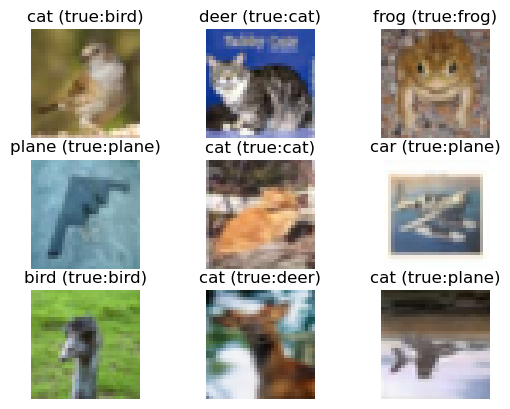

In [13]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

# Evaluate mode
# Prediction of some sample images 
with torch.no_grad():
    pred = model(images)
    _, predicted = torch.max(pred.data, 1)
    # predicted=pred.argmax(1);

figure = plt.figure()
num_of_images = 9

for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.title(f"{classes[predicted[index].item()]} (true:{classes[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.5 + 0.5).cpu().numpy().squeeze(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)


### Saving Models
* save the structure of this class together with the model

In [14]:
torch.save(model,"trained_Lenet5(CIFAR10).pth")

### Load the pretrained model

(Option 1) Loading a model with structures 

In [15]:
model = torch.load('trained_Lenet5(CIFAR10).pth', weights_only=False)

from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
---------------------------------

### Test the loaded model
Print test data accuracy 

In [16]:
loss_fn = nn.CrossEntropyLoss()

test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 53.1%, Avg loss: 1.313449 



### Visualize test results

Select random test images and evaluate

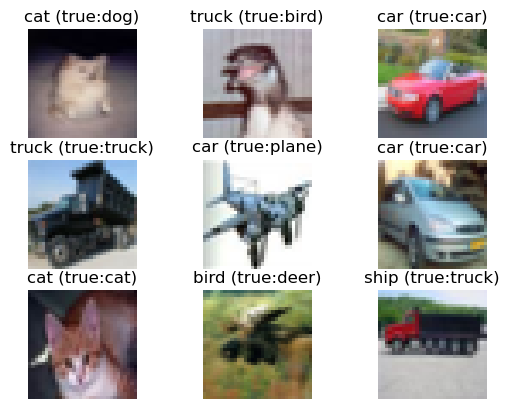

In [17]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

# Evaluate mode
# Prediction of some sample images 
with torch.no_grad():
    pred = model(images)
    _, predicted = torch.max(pred.data, 1)

figure = plt.figure()
num_of_images = 9

for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.title(f"{classes[predicted[index].item()]} (true:{classes[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.5 + 0.5).cpu().numpy().squeeze(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)


# Exercise
1. Create a module named `myModel.py`, that includes model architectures like `MLP` and `LeNet5`.

2. Load a trained model file, and verify using inference.
   
* You can reuse other modules such as train() and test() in `myModel.py`
